# 02: ANN for Regression

### 🎯 Objective
This notebook implements a simple Artificial Neural Network (ANN) to solve a regression problem. We will create a basic linear dataset, build a minimal PyTorch model, train it, and visualize its predictions.

### 📚 Key Concepts
- What **Regression** is
- Creating synthetic data
- Building a `nn.Sequential` model in PyTorch
- Using the `nn.MSELoss` loss function
- The standard training loop (Forward, Loss, Backprop, Update)
- Visualizing model predictions against real data

In [1]:
# import libraries
import numpy as np
import torch
import torch.nn as nn  # The core neural network module
import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg') # For high-quality plots

## 1. Create the Data

**Regression** is a type of supervised learning problem where the goal is to predict a **continuous numerical value** (e.g., predicting a house price, a stock value, or a temperature).

Here, we will create a simple synthetic dataset. We'll start with a variable `x`, and create a target variable `y` that is linearly related to `x` but with some added **random noise**. 

Our formula will be: $y = x + \text{noise}$

The goal of our ANN will be to learn this simple $y=x$ relationship, ignoring the noise.

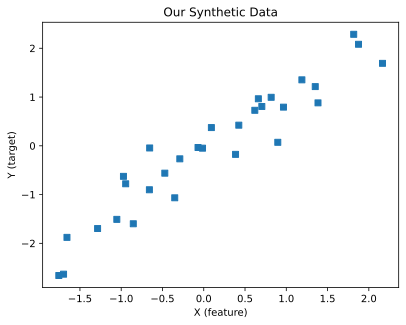

In [2]:
# create data

N = 30  # Number of data points
x = torch.randn(N,1) # Create N random numbers from a standard normal distribution
y = x + torch.randn(N,1)/2 # y is x, plus some smaller random noise

# and plot
plt.plot(x,y,'s')
plt.xlabel('X (feature)')
plt.ylabel('Y (target)')
plt.title('Our Synthetic Data')
plt.show()

## 2. Build the ANN Model

We will build a simple model using `nn.Sequential`, which is a container for stacking layers.

### Architecture:
1.  **Input Layer:** `nn.Linear(1,1)`
    * Takes 1 input feature (our `x` value) and maps it to 1 neuron.
2.  **Activation:** `nn.ReLU()`
    * Applies the Rectified Linear Unit non-linearity. This is what allows the network to learn non-linear patterns. Even though our *data* is linear, ReLU is the standard, high-performing default.
3.  **Output Layer:** `nn.Linear(1,1)`
    * Takes the 1 activated output from the hidden layer and maps it to 1 final output neuron (our prediction, $\hat{y}$).

In [3]:
# build model
ANNreg = nn.Sequential(
    nn.Linear(1,1),  # input layer: 1 input feature, 1 neuron
    nn.ReLU(),       # activation function
    nn.Linear(1,1)   # output layer: 1 neuron, 1 output value
    )

# Display the model architecture
print(ANNreg)

Sequential(
  (0): Linear(in_features=1, out_features=1, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1, out_features=1, bias=True)
)


## 3. Define Loss Function and Optimizer

Before we can train, we need to define three key things:

1.  **Learning Rate:** A small number (`0.05` here) that controls the step size of our optimizer. Too large, and the model might overshoot the solution. Too small, and it will take too long to train.
2.  **Loss Function:** `nn.MSELoss()` (Mean Squared Error). This is the standard loss function for regression. It computes the average of the squared differences between the true `y` values and the model's predictions `yHat`.
    $$J = \frac{1}{m} \sum_{i=1}^{m} (y_i - \hat{y}_i)^2$$
3.  **Optimizer:** `torch.optim.SGD` (Stochastic Gradient Descent). This is the algorithm that will update the model's weights and biases. We pass it `ANNreg.parameters()` to tell it which parameters (weights & biases) it is responsible for optimizing.

In [4]:
# learning rate
learningRate = .05

# loss function
lossfun = nn.MSELoss()

# optimizer (the flavor of gradient descent to implement)
optimizer = torch.optim.SGD(ANNreg.parameters(),lr=learningRate)

## 4. Train the Model

Now we iterate through the training process for a set number of **epochs**. An epoch is one full pass over the entire dataset.

For each epoch, we perform the four key steps:
1.  **Forward Pass:** Pass the data `x` through the model `ANNreg` to get predictions `yHat`.
2.  **Compute Loss:** Compare the predictions `yHat` to the true labels `y` using our `lossfun` (MSE).
3.  **Backpropagation:** 
    * `optimizer.zero_grad()`: We first reset the gradients to zero. PyTorch accumulates gradients by default, so we must clear them on each new epoch.
    * `loss.backward()`: This is the magic step. PyTorch automatically computes the gradients (the derivatives, e.g., $\frac{\partial J}{\partial w}$) of the loss with respect to all model parameters using the chain rule.
4.  **Optimizer Step:** `optimizer.step()`: The optimizer updates all the weights and biases using the gradients computed in the previous step and the learning rate. (e.g., $w = w - \alpha \frac{\partial J}{\partial w}$).

In [5]:
# train the model
numepochs = 500
losses = torch.zeros(numepochs) # Initialize a tensor to store losses


## Train the model!
for epochi in range(numepochs):

  # 1. forward pass
  yHat = ANNreg(x)

  # 2. compute loss
  loss = lossfun(yHat,y)
  losses[epochi] = loss # Store this epoch's loss

  # 3. backprop
  optimizer.zero_grad()  # Clear previous gradients
  loss.backward()        # Compute new gradients

  # 4. optimizer step (update weights)
  optimizer.step()

## 5. Evaluate the Training

Now that the model is trained, let's see how the loss (our MSE cost) decreased over the epochs. A good training run should show the loss dropping rapidly and then plateauing at a low value.

We also perform one final forward pass to get our `predictions` and compute the final `testloss`.

**Note on `.detach()`:**
When we want to use a PyTorch tensor for plotting or in NumPy, we must first detach it from the computation graph using `.detach()`. This tells PyTorch that we no longer need to track gradients for this tensor.

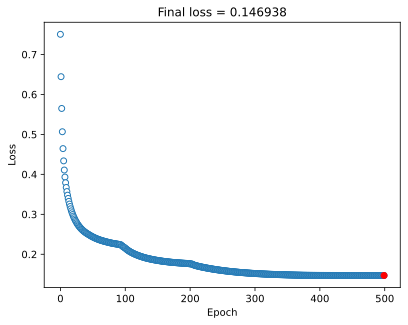

In [6]:
# show the losses

# Manually compute final predictions and loss
predictions = ANNreg(x)
testloss = (predictions-y).pow(2).mean() # .pow(2) is squared, .mean() is mean

# Plot the losses
# .detach() is necessary to convert from torch tensor to numpy array for plotting
plt.plot(losses.detach(),'o',markerfacecolor='w',linewidth=.1)
plt.plot(numepochs-1,testloss.detach(),'ro') # Plot the final loss as a red dot
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Final loss = %g' %testloss.item())
plt.show()

In [7]:
# .item() extracts the scalar value from a single-element tensor
print(f'Final Loss: {testloss.item()}')

Final Loss: 0.14693774282932281


## 6. Visualize Model Predictions

This is the most important visualization. We plot the original, noisy data (blue circles) against our model's final predictions (red squares).

Ideally, the red squares should form a straight line that captures the underlying $y=x$ relationship, effectively "seeing through" the noise.

We also compute the **Pearson Correlation Coefficient ($r$)** between the predictions and the real data. A value of $r=1.0$ would mean a perfect positive correlation.

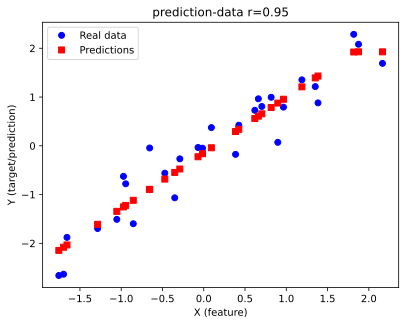

In [8]:
# plot the data
plt.plot(x,y,'bo',label='Real data')
plt.plot(x,predictions.detach(),'rs',label='Predictions')

# Compute the correlation
# .T transposes the data to be in the correct shape for np.corrcoef
corr = np.corrcoef(y.T,predictions.detach().T)[0,1]
plt.title(f'prediction-data r={corr:.2f}')

plt.legend()
plt.xlabel('X (feature)')
plt.ylabel('Y (target/prediction)')
plt.show()

# Additional explorations

1.  **How much data is "enough"?** Try different values of `N` and see how low the loss gets. Do you still get low loss ("low" is subjective, but let's say loss < 0.25) with `N=10`? `N=5`?

2.  **Does your conclusion above depend on the amount of noise in the data?** Try changing the noise level by changing the division (`/2`) when creating `y = x + torch.randn(N,1)/2`.

3.  **Notice that the model doesn't always work well.** Put the original code (that is, `N=30` and `/2` noise) into a function or a `for`-loop and repeat the training 100 times (each time using a fresh model instance). Then count the number of times the model had a loss > 0.25.